<a href="https://colab.research.google.com/github/electropavuk/crypto_trader/blob/master/ipynb/RoC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from itertools import product

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np


pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
pd.set_option('display.width', 1000)

np.set_printoptions(edgeitems=10, linewidth=200)
pd.options.mode.chained_assignment = None 

google_drive_dir = '/content/drive/MyDrive/Colab Notebooks/crypto_trader/'
data_dir = google_drive_dir + 'data/'

In [2]:
def load_history(filename):
    return pd.read_csv(data_dir + filename)

history = load_history('1h.csv')

In [3]:
def prepare_data(df, period):
    df = df[['Close']]

    prev = df['Close'].shift(period)
    df['RoC'] = (df['Close'] - prev) / prev
    df = df.dropna()
    
    return df

In [4]:
def simulate(model, data, n, money=100, commision=0.00075):

    trades = []
    init_money = balance = money
    clean = 1 - commision
    quantity = 0

    for t in range(-n, -1):
        action = model(data, t)
        price = data['Close'].iloc[t]
        if action == 'buy' and balance > 0:
            buy_price = price
            quantity = clean * balance / price
            balance = 0
            trades.append(('buy', t, price, balance))
        elif action == 'sell' and quantity > 0:
            balance = clean * quantity * price
            trades.append(('sell', t, price, balance))
            quantity = 0
    
    if quantity > 0:
        balance += quantity * buy_price
        trades.pop()
    
    profit = (balance - init_money) / init_money
    return trades, profit

In [5]:
def config_plot(plt):
    plt.figure(figsize = (30, 5))
    plt.margins(0, .1)
    plt.grid(True)

def show_graph(data, trades):
    xsell, ysell, xbuy, ybuy = [], [], [], []
    for action, t, price, _ in trades:
        if action == 'buy':
            xbuy.append(t)
            ybuy.append(price)
        if action == 'sell':
            xsell.append(t)
            ysell.append(price)

    config_plot(plt)

    x = range(-n, 0)

    # Price and trades
    plt.title('{} trades made'.format(len(trades)))
    plt.plot(x, data['Close'].iloc[-n:], label='Closing price', c='black')

    plt.scatter(xbuy, ybuy, label='Buy', c='blue')
    plt.scatter(xsell, ysell, label='Sell', c='red')
    plt.legend()


def show_roc(data):
    config_plot(plt)
    plt.title('RoC')
    plt.plot(range(-n, 0), data['RoC'])


def show_profit(data, trades):
    config_plot(plt)
    xprofit, yprofit = [], []
    balance = init_money = money
    for action, t, price, balance in trades:
        if balance > 0:
            xprofit.append(t)
            yprofit.append(100 * (balance - init_money) / init_money)


    plt.title('Profit')
    plt.plot(xprofit, yprofit, label='Profit', c='black', linestyle=':')
    plt.legend()

In [6]:
class ROCCrossover:
    def __init__(self, period=24, patience=1):
        self.period = period
        self.patience = patience

    def __call__(self, data, t):
        roc = data['RoC'].iloc[t-self.patience+1: t+1].values
        if roc[0] < 0 and all(roc[1:] > 0):
            return 'buy'
        elif roc[0] > 0 and all(roc[1:] < 0):
            return 'sell'
        else:
            return 'wait'

In [7]:
def search_parameters(patience, periods):
    params = product(patience, periods)
    profits = []
    for patience, period in params:
        data = prepare_data(history, period)[-n:]
        model = ROCCrossover(period, patience=patience)
        trades, profit = simulate(model, data, n, money=money, commision=0.00075)
        print('params {} : profit = {:.1f} %'.format((patience, period), profit * 100))
        profits.append((profit, (patience, period)))

    profit, (patience, period) = max(profits)
    print('BEST')
    print('params {} : profit = {:.1f} %'.format((patience, period), profit * 100))
    return patience, period

profit 173.1038759661879%


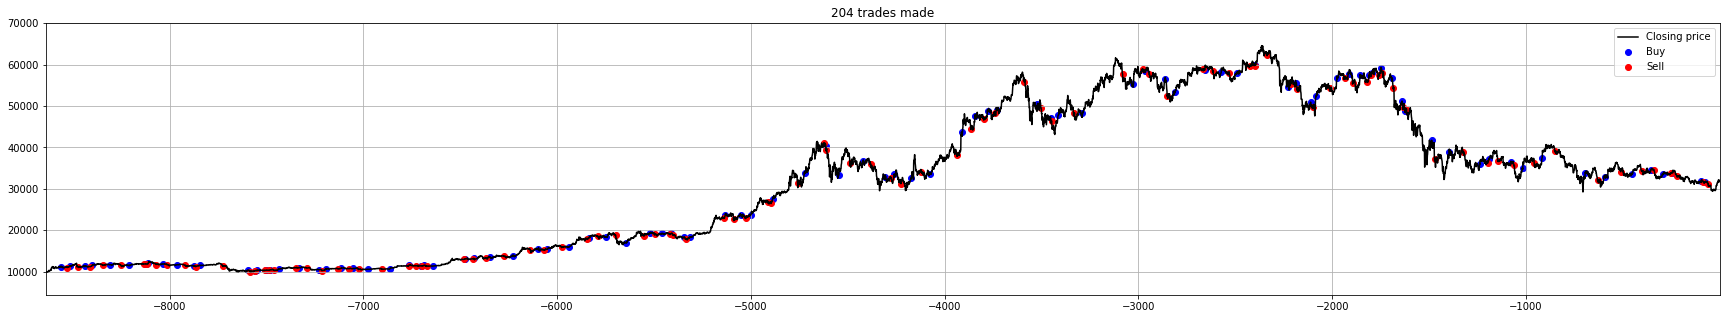

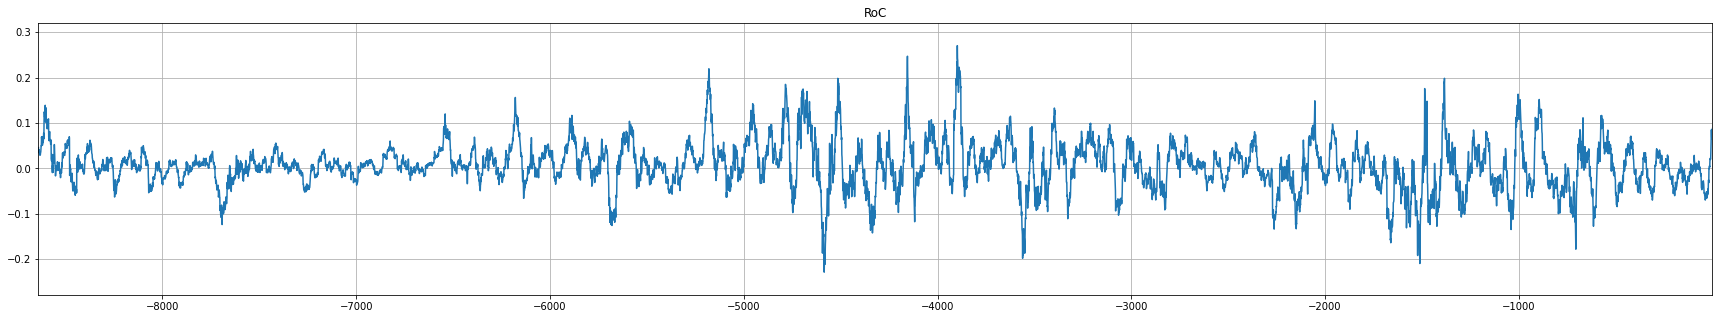

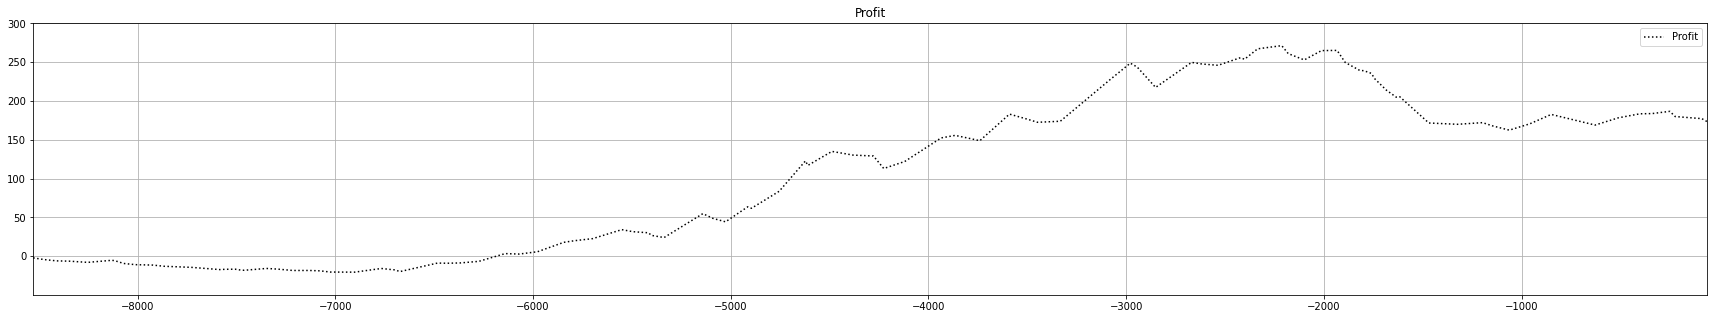

In [8]:
money = 100
n = 24 * 360
period = 20

history = load_history('1h.csv')
# patience, period = search_parameters(range(4, 10), range(7, 49))
patience, period = 5, 37 # 1h, 360 days
# patience, period = 5, 34 # 1h, 60 days

data = prepare_data(history, period)[-n:]
model = ROCCrossover(period=period, patience=patience)
trades, profit = simulate(model, data, n, money=money, commision=0.00075)


print(f'profit {100*profit}%')
show_graph(data, trades)
show_roc(data)
show_profit(data, trades)